In [28]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.cluster.hierarchy as sch
from seaborn.matrix import dendrogram
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
wine = pd.read_csv('wine.csv')


In [30]:
y = wine['quality']
X = wine.drop(columns=['quality'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [32]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print('MAE', round(mae,2))


MAE 0.42


In [33]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

100%|===================| 977/980 [00:19<00:00]        

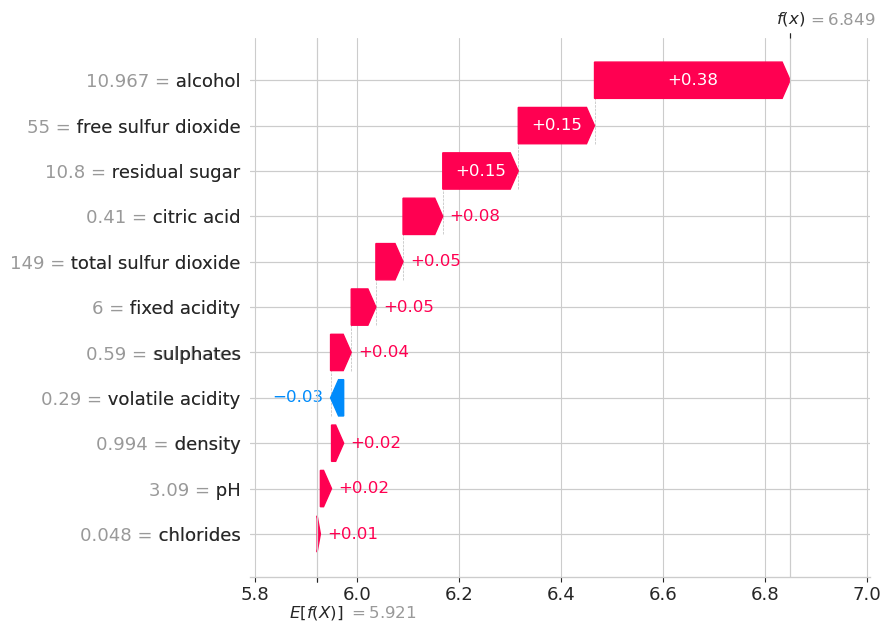

In [34]:
shap.plots.waterfall(shap_values[0],  max_display=11)

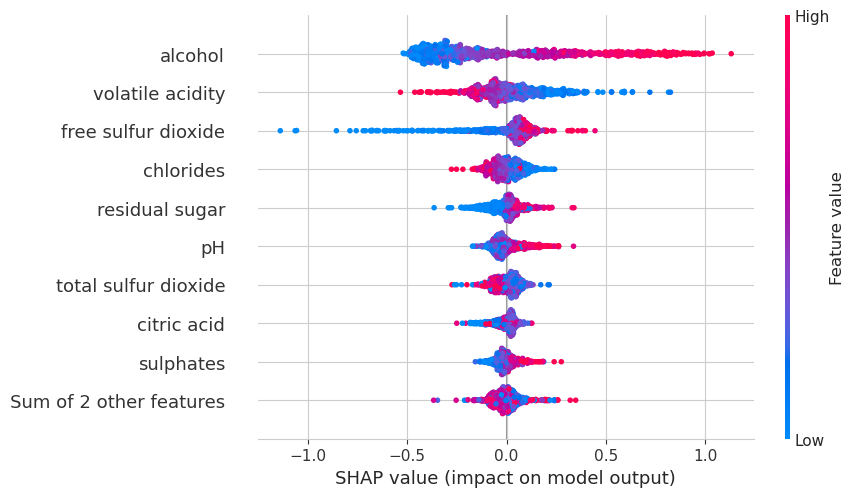

In [35]:
shap.plots.beeswarm(shap_values)

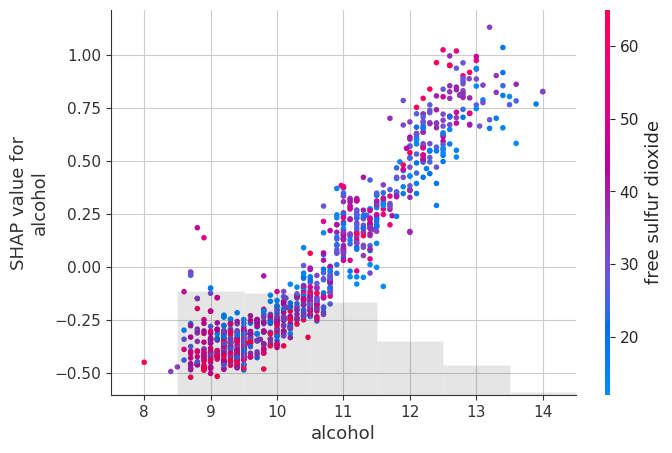

In [36]:
shap.plots.scatter(shap_values[:, 'alcohol'], color=shap_values)

<Axes: >

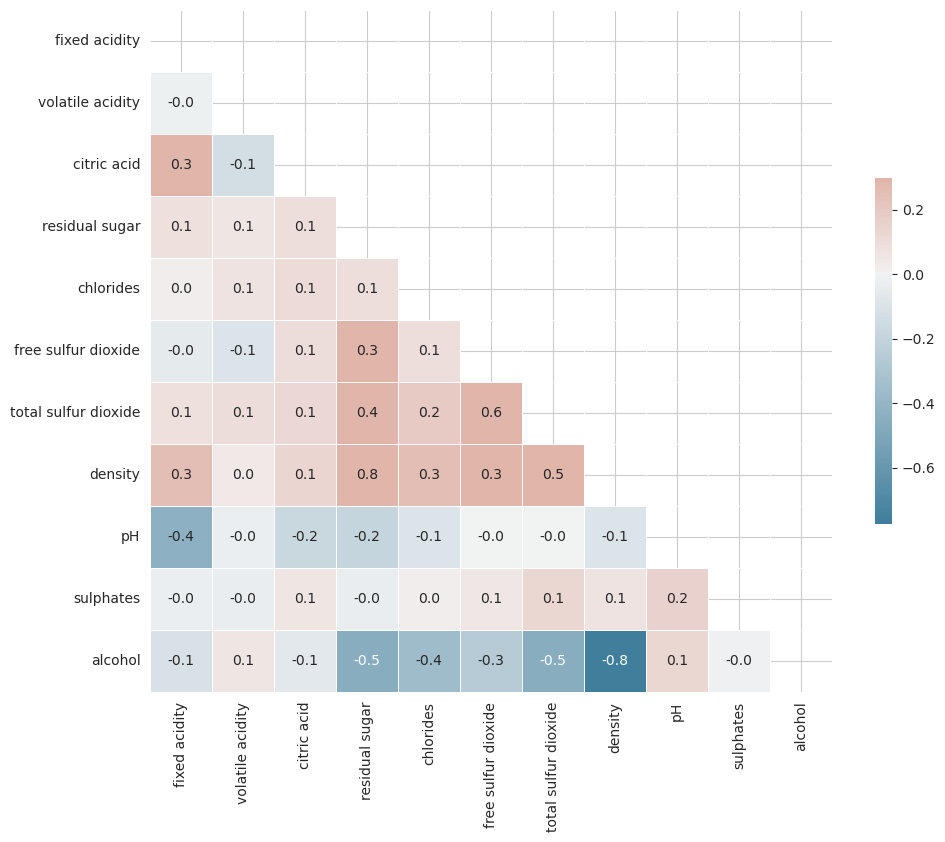

In [37]:
corr    = X_train.corr()
mask    = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(11, 9))
cmap    = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.1f')

In [38]:
correlation_matrix = X_train.corr()
correlation_matrix = np.corrcoef(correlation_matrix)
correlation_matrix = np.abs(correlation_matrix)
dist_matrix = 1 - correlation_matrix

In [39]:
clustering = sch.linkage(dist_matrix, method='complete')


/tmp/ipykernel_1043/1813551694.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clustering = sch.linkage(dist_matrix, method='complete')


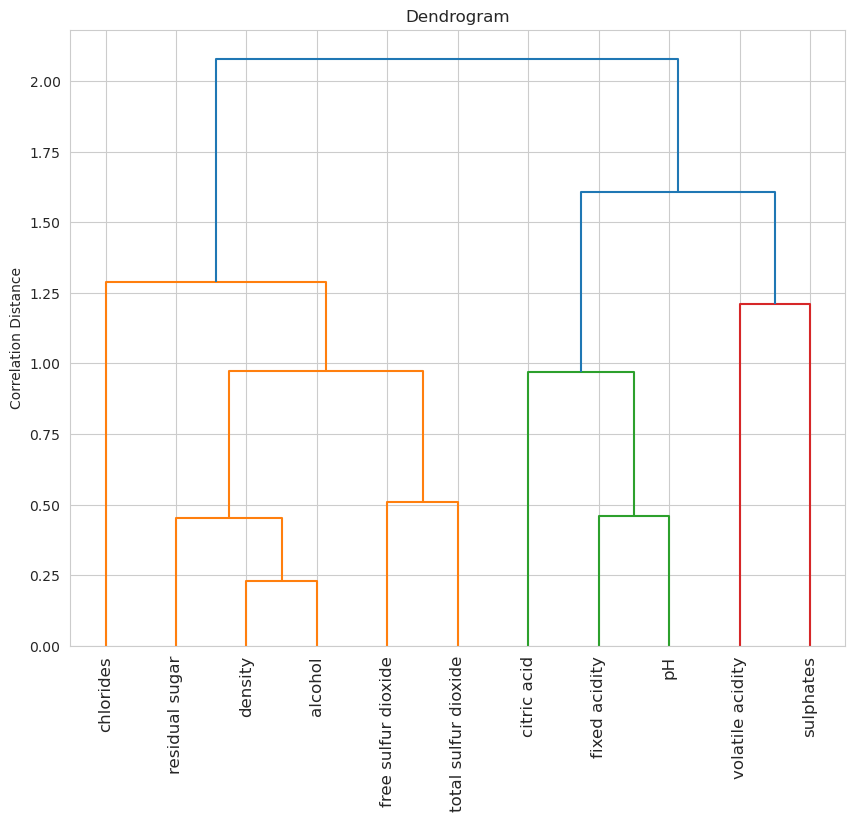

In [40]:
plt.figure(figsize=(10, 8))
plt.title('Dendrogram')

dend       = sch.dendrogram(clustering, labels=X_train.columns)
plt.xticks(rotation=90)
plt.ylabel('Correlation Distance')
plt.show()

In [41]:
masker = shap.maskers.Partition(X_train, clustering=clustering)
explainer2 = shap.PartitionExplainer(model.predict, masker=masker)
shap_values2 = explainer2(X_test)

/home/aswin/miniconda3/envs/regression/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/aswin/miniconda3/envs/regression/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/aswin/miniconda3/envs/regression/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/aswin/miniconda3/envs/regression/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/aswin/miniconda3/envs/regression/lib/python3.12/site-packages/sklearn/utils/validation.py:2739

KeyboardInterrupt: 

In [ ]:
X_train